If Wordcloud is not already installed on your system please enter these commands in the terminal:
1. git clone https://github.com/amueller/word_cloud.git
2. cd word_cloud
3. pip install .

Now import all modules

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.datasets import fetch_20newsgroups

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /Users/bryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


There are 20 categories in the loaded dataset.<br>
We will only load the following 4 categories for this to be a simpler example:
- alt.atheism
- soc.religion.christian
- comp.graphics
- sci.med

For these cagegories we load in the train and test subsets, shuffling while loading.

In [2]:
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
X_train = train_data.data
y_train = train_data.target


test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
X_test = test_data.data
y_test = test_data.target

First take a look at what has been loaded and examine a single document.

In [3]:
print("Target Names: ", train_data.target_names)

print("\nNumber of Training Examples: ", len(X_train))
print("Number of Training Labels: ", len(y_train))

print("Number of Test Examples: ",len(X_test))
print("Number of Test Labels: ", len(y_test))


print("\nPrint a Random Document:\n")
print(X_train[0])

Target Names:  ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

Number of Training Examples:  2257
Number of Training Labels:  2257
Number of Test Examples:  1502
Number of Test Labels:  1502

Print a Random Document:

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



Now create a dataframe from the data and count how many of each category we have.<br>
The code for classifications is as given below:<br>
0 = 'alt.atheism', 1 = 'soc.religion.christian',2 = 'comp.graphics', 3 = 'sci.med'

In [4]:
df_full=pd.DataFrame(train_data.target)

# Count up number of times each class occurs
label_counts = df_full.iloc[:,-1].value_counts()

print(label_counts)

3    599
2    594
1    584
0    480
Name: 0, dtype: int64


We now create a histogram of the number of messages corresponding to each category in our dataset

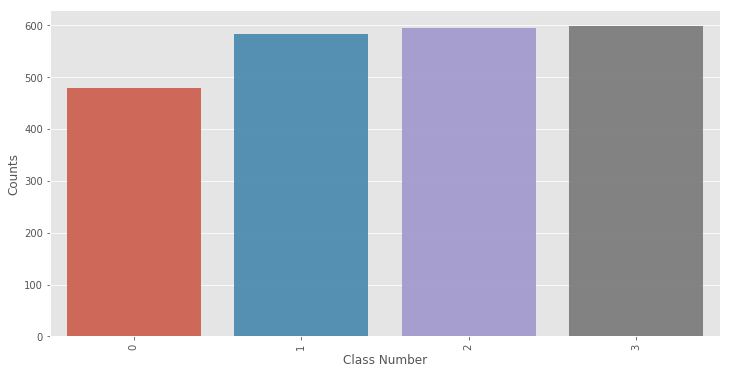

In [5]:
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Class Number', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

Now create the train and test pandas dataframes.<br>
We want them to be dataframes as the next step involves normalization, which is simpler if they are in dataframe format.

In [6]:
# I first move the training and testing feature matrices into pandas dataframes
df_xTrain = pd.DataFrame()
df_xTest = pd.DataFrame()

df_xTrain['text_raw'] = X_train
df_xTest['text_raw'] = X_test
df_xTrain.head()

,text_raw
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...
4,From: stanly@grok11.columbiasc.ncr.com (stanly...


Below we apply Stemming or Lemmatizing to each word in every message.<br>
These results are added as separate columns within the same test and train dataframes we created earlier.

In [7]:
# Use a Lemmatizer and see the effect
lemmatizer = WordNetLemmatizer()
df_xTrain['text_lemmatized'] = df_xTrain['text_raw'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)))
df_xTest['text_lemmatized'] = df_xTest['text_raw'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)))

# Use a Porter Stemmer and see the effect
stemmer = PorterStemmer()
df_xTrain['text_porter_stemmed'] = df_xTrain['text_raw'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text)))
df_xTest['text_porter_stemmed'] = df_xTest['text_raw'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text)))

# Use a Lancaster Stemmer and see the effect
stemmer = LancasterStemmer()
df_xTrain['text_lancaster_stemmed'] = df_xTrain['text_raw'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text)))
df_xTest['text_lancaster_stemmed'] = df_xTest['text_raw'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text)))

# Observe a random document to see the effect of each
doc_num = 1
print(df_xTrain['text_raw'][doc_num])
print("\nLemmatized Email:\n")
print(df_xTrain['text_lemmatized'][doc_num])
print("\n Porter Stemmed Email:\n")
print(df_xTrain['text_porter_stemmed'][doc_num])
print("\n Lancaster Stemmed Email:\n")
print(df_xTrain['text_lancaster_stemmed'][doc_num])

From: ani@ms.uky.edu (Aniruddha B. Deglurkar)
Subject: help: Splitting a trimming region along a mesh 
Organization: University Of Kentucky, Dept. of Math Sciences
Lines: 28



	Hi,

	I have a problem, I hope some of the 'gurus' can help me solve.

	Background of the problem:
	I have a rectangular mesh in the uv domain, i.e  the mesh is a 
	mapping of a 3d Bezier patch into 2d. The area in this domain
	which is inside a trimming loop had to be rendered. The trimming
	loop is a set of 2d Bezier curve segments.
	For the sake of notation: the mesh is made up of cells.

	My problem is this :
	The trimming area has to be split up into individual smaller
	cells bounded by the trimming curve segments. If a cell
	is wholly inside the area...then it is output as a whole ,
	else it is trivially rejected. 

	Does any body know how thiss can be done, or is there any algo. 
	somewhere for doing this.

	Any help would be appreciated.

	Thanks, 
	Ani.
-- 
To get irritated is human, to stay cool, divi

We now create the pipeline we will use for performing hyperparameter tuning.

In [8]:
text_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB()),
    ])

Define the parameters over which you will perform the hyperparameter optimization.

In [9]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'vect__binary': [True, False],
    'clf__alpha': [0.1, 1.0, 1.5, 1.8],
}

Here we define the gridsearch we will be applying below.

In [10]:
# As using f1 score works only for binary class targets we instead implement f1_micro
clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1_micro', cv=5)

For below we choose to define our feature matrix depending on no normalizing (raw) or by choosing one of the normalizing approaches.<br>
Note once X_train_proc and X_test_proc are defined here they are used below, so uncomment only the normalizing approach (or lack thereof) you want to apply below.

In [11]:
X_train_proc = df_xTrain['text_raw'] # Use raw data
X_test_proc = df_xTest['text_raw'] # Use raw data

# X_train_proc = df_xTrain['text_lemmatized'] # Use lemmatized data
# X_test_proc = df_xTest['text_lemmatized'] # Use lemmatized data

# X_train_proc = df_xTrain['text_porter_stemmed'] # Use porter stemmed data
# X_test_proc = df_xTest['text_porter_stemmed'] # Use porter stemmed data

# X_train_proc = df_xTrain['text_lancaster_stemmed'] # Use lancaster stemmed data
# X_test_proc = df_xTest['text_lancaster_stemmed'] # Use lancaster stemmed data

Now apply hyperparameter optimization using the normalization approach chosen above

In [12]:
clf_multinomial_cv = clf_multinomial_cv.fit(X_train_proc, y_train)


print("\nBest Score: %f" % clf_multinomial_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, clf_multinomial_cv.best_params_[param_name]))


Best Score: 0.981391

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__binary: True
vect__ngram_range: (1, 2)
vect__stop_words: 'english'


Below I have recorded the optimal parameters found for all normalization approaches tested above<br>
Uncomment the parameters corresponding to the normalization approach you have chosen to apply.

In [13]:
# In this box uncomment the optimal hyperparameters for the lemmatization/stemming performed

# Below was done for raw data
stop_words_opt = 'english'
ngram_range_opt = (1, 2)
binary_opt = True
clf_alpha_opt = 0.1

# Below was done for lemmatized data
# stop_words_opt = 'english'
# ngram_range_opt = (1, 2)
# binary_opt = True
# clf_alpha_opt = 0.1

# Below was done for Porter Stemmed Data
# stop_words_opt = 'english'
# ngram_range_opt = (1, 2)
# binary_opt = True
# clf_alpha_opt = 0.1

# Below was done for Lancaster Stemmed Data
# stop_words_opt = None
# ngram_range_opt = (1, 2)
# binary_opt = True
# clf_alpha_opt = 0.1

I now create the pipeline I will use for evaluating the test data

In [14]:
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words=stop_words_opt, ngram_range=ngram_range_opt, binary=binary_opt)),
        ('clf', MultinomialNB(alpha=clf_alpha_opt)),
    ])

Now fit the training data to this pipeline, meaning all chosen parameters

In [15]:
multinomialNB_clf.fit(X_train_proc, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

Now apply this model to the test data and see how effective it is at categorizing messages

In [16]:
# Make prediction
y_test_predicted = multinomialNB_clf.predict(X_test_proc)

print("\nTest Confusion Matrix for Multinomial NB:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted,average='micro') 
print("\nTest Precision for Multinomial NB = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted,average='micro')
print("Test Recall for Multinomial NB = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted,average='micro')
print("Test F1 Score for Multinomial NB = %f" % f1_test)

print("\nClassification Report for Multinomial NB:")
print(classification_report(y_test, y_test_predicted, target_names = ['alt.atheism (0)', 'soc.religion.christian (1)','comp.graphics (2)', 'sci.med (3)']))


Test Confusion Matrix for Multinomial NB:
[[297   3   6  13]
 [  4 375   9   1]
 [  5  19 360  12]
 [  4   2   7 385]]

Test Precision for Multinomial NB = 0.943409
Test Recall for Multinomial NB = 0.943409
Test F1 Score for Multinomial NB = 0.943409

Classification Report for Multinomial NB:
                            precision    recall  f1-score   support

           alt.atheism (0)       0.96      0.93      0.94       319
soc.religion.christian (1)       0.94      0.96      0.95       389
         comp.graphics (2)       0.94      0.91      0.93       396
               sci.med (3)       0.94      0.97      0.95       398

                 micro avg       0.94      0.94      0.94      1502
                 macro avg       0.94      0.94      0.94      1502
              weighted avg       0.94      0.94      0.94      1502



We now test the same model, but now with TFIDF as well.<br>
Below is the pipeline used for this

In [17]:
text_tfidf_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

We now use set up this pipeline with the optimal parameters found above.<br>
Note that technically we should apply hyperparameter optimization again, but I have not tested this yet

In [18]:
multinomialNB_clf_tfidf = Pipeline([
        ('vect', CountVectorizer(stop_words=stop_words_opt, ngram_range=ngram_range_opt, binary=binary_opt)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=clf_alpha_opt)),
    ])  

Now fit this to the training data

In [19]:
multinomialNB_clf_tfidf.fit(X_train_proc, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        s...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

Now use this model to make predictions on the test data

In [20]:
# Make prediction
y_test_predicted = multinomialNB_clf_tfidf.predict(X_test_proc)

print("\nTest Confusion Matrix for Multinomial NB With TFIDF:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted,average='micro') 
print("\nTest Precision for Multinomial NB With TFIDF = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted,average='micro')
print("Test Recall for Multinomial NB With TFIDF = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted,average='micro')
print("Test F1 Score for Multinomial NB With TFIDF = %f" % f1_test)

print("\nClassification Report for Multinomial NB With TFIDF:")
print(classification_report(y_test, y_test_predicted, target_names = ['alt.atheism (0)', 'soc.religion.christian (1)','comp.graphics (2)', 'sci.med (3)']))


Test Confusion Matrix for Multinomial NB With TFIDF:
[[276   3  11  29]
 [  1 372   8   8]
 [  4  22 353  17]
 [  4   3   6 385]]

Test Precision for Multinomial NB With TFIDF = 0.922770
Test Recall for Multinomial NB With TFIDF = 0.922770
Test F1 Score for Multinomial NB With TFIDF = 0.922770

Classification Report for Multinomial NB With TFIDF:
                            precision    recall  f1-score   support

           alt.atheism (0)       0.97      0.87      0.91       319
soc.religion.christian (1)       0.93      0.96      0.94       389
         comp.graphics (2)       0.93      0.89      0.91       396
               sci.med (3)       0.88      0.97      0.92       398

                 micro avg       0.92      0.92      0.92      1502
                 macro avg       0.93      0.92      0.92      1502
              weighted avg       0.93      0.92      0.92      1502



Note that as we did not perform cross-validation after including TFIDF this could be one possible explanation for the drop in precion and recall.

We now implement Multivariate Bernoulli Naive Bayes<br>
We first build a pipeline using the same optimal parameters found above.<br>
Note that technically we should apply hyperparameter optimization again, but I have not tested this yet

In [21]:
bernoulliNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=True)),
        ('clf', BernoulliNB(alpha=0.1)),
    ])

Now fit this to the training data

In [22]:
bernoulliNB_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True))])

We now evaluate this Multivariate Bernoulli Naive Bayes model on the test data

In [23]:
# Make prediction
y_test_predicted = bernoulliNB_clf.predict(X_test_proc)

print("\nTest Confusion Matrix for Multivariate Bernoulli NB:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted,average='micro') 
print("\nTest Precision for Multivariate Bernoulli NB = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted,average='micro')
print("Test Recall for Multivariate Bernoulli NB = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted,average='micro')
print("Test F1 Score for Multivariate Bernoulli NB = %f" % f1_test)

print("\nClassification Report for Multivariate Bernoulli NB:")
print(classification_report(y_test, y_test_predicted, target_names = ['alt.atheism (0)', 'soc.religion.christian (1)','comp.graphics (2)', 'sci.med (3)']))


Test Confusion Matrix for Multivariate Bernoulli NB:
[[288  18   5   8]
 [  2 385   2   0]
 [  3 107 284   2]
 [  3  36   1 358]]

Test Precision for Multivariate Bernoulli NB = 0.875499
Test Recall for Multivariate Bernoulli NB = 0.875499
Test F1 Score for Multivariate Bernoulli NB = 0.875499

Classification Report for Multivariate Bernoulli NB:
                            precision    recall  f1-score   support

           alt.atheism (0)       0.97      0.90      0.94       319
soc.religion.christian (1)       0.71      0.99      0.82       389
         comp.graphics (2)       0.97      0.72      0.83       396
               sci.med (3)       0.97      0.90      0.93       398

                 micro avg       0.88      0.88      0.88      1502
                 macro avg       0.91      0.88      0.88      1502
              weighted avg       0.90      0.88      0.88      1502



One issue which I have with the approach taken in this notebook is that we perform cross-validation only on the model which included multinomial Naive-Bayes Classification. We never re-performed cross-validation after including TFIDF as well, or after implimenting the multivariate Bernouli model. This thus could skew some of the results. With that in mind our summary of results are below:


Below is a summary of the weighted average for all error metrics using no Lemmatization or Stemming:<br>
Multinomial Naive Bayes: Precision=0.94 .  Recall=0.94 .  F1-Score=0.94<br>
MultiNomial Naive Bayes with TFIDF: Precision=0.93 .  Recall=0.92 .  F1-Score=0.92<br>
Multivariate Bernoulli: Precision=0.90 .  Recall=0.88 .  F1-Score=0.88<br>

Below is a summary of the weighted average for all error metrics using Lemmatization:<br>
Multinomial Naive Bayes: Precision=0.94 .  Recall=0.94 .  F1-Score=0.94<br>
MultiNomial Naive Bayes with TFIDF: Precision=0.93 .  Recall=0.92 .  F1-Score=0.92<br>
Multivariate Bernoulli: Precision=0.90 .  Recall=0.87 .  F1-Score=0.87<br>

Below is a summary of the weighted average for all error metrics using Porter Stemming:<br>
Multinomial Naive Bayes: Precision=0.94 .  Recall=0.94 .  F1-Score=0.94<br>
MultiNomial Naive Bayes with TFIDF: Precision=0.92 .  Recall=0.92 .  F1-Score=0.92<br>
Multivariate Bernoulli: Precision=0.87 .  Recall=0.80 .  F1-Score=0.81<br>

Below is a summary of the weighted average for all error metrics using Lancaster Stemming:<br>
Multinomial Naive Bayes: Precision=0.93 .  Recall=0.93 .  F1-Score=0.93<br>
MultiNomial Naive Bayes with TFIDF: Precision=0.90 .  Recall=0.90 .  F1-Score=0.90<br>
Multivariate Bernoulli: Precision=0.85 .  Recall=0.73 .  F1-Score=0.73<br>


From the above results it appears that regardless of the pre-processing (lemitization or stemming) performed that the Multinomial Naive Bayes Classification provides the optimal results. As the Multinomial Naive Bayes Classification with TFIDF performs slightly worse it appears that weighting particular words by frequency actually hurts the predictive ability, at least for categorizing for these categories. That multivariate bernouli performs worst indicates that for categorizing these type of messages the frequency of the words (how often they are used per message) does contain important predictive information.<br>

For assessing the impact of Lemmatization and Stemming we tested each separately. Due to lack of time we did not test chained combinations, where for example we could have performed lemmatization and then stemming. Performing each separately showed that, surprisingly, there was not a significant improvement in performing stemming or lemitization. In fact, lemmatization provided no improvement for Multinomial Naive Bayes or Multinomial Naive Bayes with TFIDF but actually decreased the predictive ability for Multivariate Bernoulli. Stemming performed even worse. For both types of stemming assessed these caused a decrease in predictive ability for every Naive Bayes model used. Thus, we conclude that for this classification it is probably best to not utilize lemmatization or stemming.<br>

In conlcusion, the above results lead us to recommend the following model for performing this classification. No normalization should be used, and for the classification model we recommend using Multinomial Naive Bayes with the following hyperparameters:<br>
stop_words = 'english'<br>
ngram_range = (1, 2)<br>
binary = True<br>
clf_alpha = 0.1<br>